In [ ]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import time
from sklearn.metrics import mean_squared_error,r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Data preprocessing
def EDA(df):
	#creating dataframe with date and the target variable
	data = df.sort_index(ascending=True, axis=0)
	# Generate new dataframe
	new_data = pd.DataFrame()
	new_data["Production"] = data["Production"]
	return new_data

# To find out order of AR
def plotting_pacf(df, sequence_length):
	plot_pacf(df.Production, lags = sequence_length)
	plt.show()

# Generate required dataset
def required_dataset(df,train_size):
	# After finding pacf value, only first ordered AR is considered
	df["Shifted_by_1"] = df["Production"].shift()
	df.dropna(inplace=True)
	# Define dependent and independent variable
	y = df["Production"].values
	X = df["Shifted_by_1"].values
	# Generate train and test dataset
	X_train, X_test = X[0:train_size], X[train_size:len(X)]
	y_train, y_test = y[0:train_size], y[train_size:len(X)]
	X_train = X_train.reshape(-1,1)
	X_test = X_test.reshape(-1,1)
	return X_train, y_train, X_test, y_test

# To find out coefficient and intercept of the AR model
def fit_model(X,y,train_size):
	sum_x, sum_x2, sum_y, sum_xy, n = 0.0,0.0,0.0,0.0, train_size
	for i in range(len(X)):
		sum_x += X[i][0]
		sum_x2 += X[i][0] **2
		sum_y += y[i]
		sum_xy += X[i][0]*y[i]
	# Calculate coefficient and intercept
	Coefficient = (n*sum_xy-sum_x*sum_y)/(n*sum_x2 - sum_x**2)
	Intercept = (sum_y*sum_x2 - sum_x*sum_xy)/(n*sum_x2 - sum_x**2)
	return Coefficient, Intercept

def predictions(Coefficient, Intercept, X):
	y_pred = Coefficient * X + Intercept
	return y_pred

def rmse(y_test, y_pred):
	RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
	return RMSE

def final_plot(y_test, y_pred):
	# Plot
	plt.plot(y_test, label="Actual Values")
	plt.plot(y_pred, label="Predicted Values")
	plt.legend()
	plt.show()

In [ ]:
time_taken = []
for _ in range(5):
  # Starting timer
  start = time.time()
  df = pd.read_csv("crop_prod_clean.csv")
  new_data = EDA(df)
  # print(new_data)
  #To check pacf plot
  #plotting_pacf(new_data, 30)
  # declare training data size
  train_size = int(len(new_data) * 0.80)
  X_train, y_train, X_test, y_test = required_dataset(new_data, train_size)
  Coefficient, Intercept = fit_model(X_train, y_train, train_size)
  y_pred = predictions(Coefficient, Intercept, X_test)
  RMSE = rmse(y_test, y_pred)
  r2 = r2_score(y_test,y_pred)
  # End timer
  end = time.time()
  time_taken.append(end-start)
print(df.size)
print("The RMSE is :", RMSE)
print("The R^2 value is: ",r2)
print("Average time taken by serial code = ",np.mean(time_taken), " seconds")
# To check final plot after predictions
# final_plot(y_test,y_pred)

1968608
The RMSE is : 19217839.515648425
The R^2 value is:  -0.00021295542807053813
Average time taken by serial code =  0.6672359943389893  seconds


In [ ]:
# importing libraries
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import time
from sklearn.metrics import mean_squared_error, r2_score
from numba import config, njit, set_num_threads, prange
# Setting the OPENMP threading layer
config.THREADING_LAYER = 'omp'
#set_num_threads(4)
#config.NUMBA_NUM_THREADS = 2

In [ ]:
# Data preprocessing
def EDA(df):
	# setting the index as date
	# df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
	# df.index = df['Date']

	#creating dataframe with date and the target variable
	data = df.sort_index(ascending=True, axis=0)
	# Generate new dataframe
	new_data = pd.DataFrame()
	# new_data["Date"] = data["Date"]
	new_data["Production"] = data["Production"]
	return new_data

# To find out order of AR
def plotting_pacf(df, sequence_length):
	plot_pacf(df.Production, lags = sequence_length)
	plt.show()

# Generate required dataset
def required_dataset(df,train_size):
	# After finding pacf value, only first ordered AR is considered
	df["Shifted_by_1"] = df["Production"].shift()
	df.dropna(inplace=True)
	# Define dependent and independent variable
	y = df["Production"].values
	X = df["Shifted_by_1"].values
	# Generate train and test dataset
	X_train, X_test = X[0:train_size], X[train_size:len(X)]
	y_train, y_test = y[0:train_size], y[train_size:len(X)]
	X_train = X_train.reshape(-1,1)
	X_test = X_test.reshape(-1,1)
	return X_train, y_train, X_test, y_test

@njit(parallel = True)
def fitting_model(X,y,train_size):
	sum_x, sum_x2, sum_y, sum_xy, n = 0.0,0.0,0.0,0.0, train_size
	for i in prange(len(X)):
		sum_x += X[i][0]
		sum_x2 += X[i][0] **2
		sum_y += y[i]
		sum_xy += X[i][0]*y[i]
	# Calculate coefficient and intercept
	Coefficient = (n*sum_xy-sum_x*sum_y)/(n*sum_x2 - sum_x**2)
	Intercept = (sum_y*sum_x2 - sum_x*sum_xy)/(n*sum_x2 - sum_x**2)
	return Coefficient, Intercept

def predictions(Coefficient, Intercept, X):
	y_pred = Coefficient * X + Intercept
	return y_pred

def rmse(y_test, y_pred):
	RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
	return RMSE

def final_plot(y_test, y_pred):
	# Plot
	plt.plot(y_test, label="Actual Values")
	plt.plot(y_pred, label="Predicted Values")
	plt.legend()
	plt.show()

In [ ]:

tdz = np.array([2, 4, 8, 16, 32, 64, 128]) 
ttime = []
ttime.append(0.6672359943389893)
for i in tdz:
	config.NUMBA_NUM_THREADS = i
	time_taken = []
	for _ in range(5):
		# Actual 
		# Starting timer
		start = time.time()
		df = pd.read_csv("crop_prod_clean.csv")
		new_data = EDA(df)
		# To check pacf plot
		# plotting_pacf(new_data, 30)
		# declare training data size
		train_size = int(len(new_data) * 0.80)
		X_train, y_train, X_test, y_test = required_dataset(new_data, train_size)
		Coefficient, Intercept = fitting_model(np.array(X_train), np.array(y_train), train_size)
		y_pred = predictions(Coefficient, Intercept, X_test)
		RMSE = rmse(y_test, y_pred)
		r2 = r2_score(y_test, y_pred)
		# End timer
		end = time.time()
		time_taken.append(end-start)
	ttime.append(np.mean(time_taken))
print("The RMSE is :", RMSE)
print("The R^2 value is: ",r2)
for i in range(len(tdz)):
	print("Average time taken by ",tdz[i],"\t","threads: ",ttime[i+1],)
# fitting_model.parallel_diagnostics(level=4)
# To check final plot after predictions
# final_plot(y_test,y_pred)

The RMSE is : 19217839.51564842
The R^2 value is:  -0.00021295542807053813
Average time taken by  2 	 threads:  0.18798470497131348
Average time taken by  4 	 threads:  0.18949284553527831
Average time taken by  8 	 threads:  0.18807435035705566
Average time taken by  16 	 threads:  0.19359636306762695
Average time taken by  32 	 threads:  0.18922114372253418
Average time taken by  64 	 threads:  0.18378772735595703
Average time taken by  128 	 threads:  0.1841531753540039


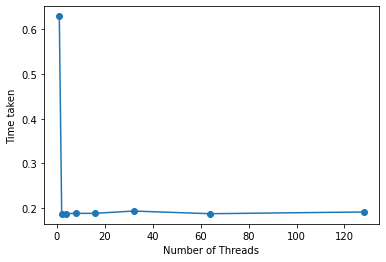

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
  
# define data values
x = np.array([1, 2, 4, 8, 16, 32, 64, 128])  
y = np.array(ttime)
  
plt.plot(x, y, "-o")
plt.xlabel("Number of Threads")
plt.ylabel("Time taken")
plt.show() 